# Klasszikus architektúrák

Megvizsgáltuk tehát hogy a konvolúciós architektúrák kisebb paraméterszámmal ugyanakkor nagyobb teljesítménnyel, tehát szignifikánsan jobb hatékonysággal működnek képi klasszifikáció esetén mint a teljesen összekötött rétegekből készített neurális hálózatok.

Felmerülhet kérdésként, hogy mi az ideális architektúra egy adott probléma megoldására: erre azonban nem könnyű felelni, ugyanis függ az adatok eloszlásától, mennyiségétől, felbontásától, a képek minőségétől, és a sort hosszan lehet folytatni...

Az elmúlt évek során többféle struktúrát publikáltak a kutatók, ezekből néhány általános ökölszabályt figyelhetünk meg, melyeket korábban alkalmaztunk is: Pooling esetén a maximális érték használata célszerű, ReLU aktivációk mellett, a konvolúciós kernelek mérete legyen lehetőség szerint minél kisebb, a filterszám pedig a mélyebb rétegekben lehetőség szerint egyre növekedjen.

Felmerülhet ötletként, hogy esetleg egy ismert architektúrát használjunk fel, például a korábban bemutatott ILSVRC díjnyertes modelljei alapján.

Oldjuk meg a korábbi Cats vs Dogs problémát ismert architektúrákkal!

In [1]:
from keras.preprocessing.image import ImageDataGenerator

imsize = 224

train_gen = ImageDataGenerator(rescale=1./255, 
                               featurewise_std_normalization=True)

train_data = train_gen.flow_from_directory("catsvsdogs\\training_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           #batch_size=16
                                           batch_size=8
                                          )

test_gen = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True)

test_data = train_gen.flow_from_directory("catsvsdogs\\test_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           #batch_size=16
                                           batch_size=8
                                         )

c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


A jól ismert VGG-16 modell jó eredményeket ért el, esetleg felépíthetjük ezt:

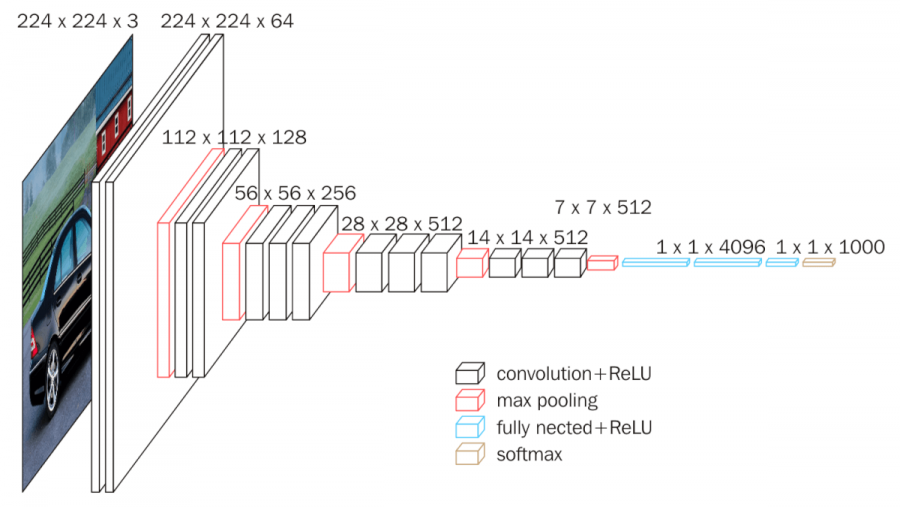

A Keras egyik nagy segítsége a fejlesztők felé, hogy nem kell újra fetalálni a kereket -- vagy legalábbis nem kell újra implementálni:

In [2]:
from keras.applications.vgg16 import VGG16

model = VGG16(include_top=True, weights=None, classes=1)

Konstruktorban megadjuk, hogy a "felső" input réteget is szeretnénk alkalmazni, előre betanított súlyokat nem szeretnénk betölteni (az ImageNet ILSVRC paraméterek betöltésére lenne lehetőség). A kimeneti osztályok száma $1$; hisz valójában bináris klasszifikátort építünk.

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

A 134 millió paraméter rettentő sok: ha nem áll rendelkezésre GPU, akkor a tanítás folyamata nagyon lassú lesz. Erre az esetre lehetőség van kisebb paraméterszámú architektúrát is használni, például az itt bemutatott MobileNetv2 mindössze 2 millió tanítható paraméterből áll.

Ha van rendelkezésre álló GPU, ezeket a sorokat célszerű kihagyni!

In [4]:
from keras.applications.mobilenet_v2 import MobileNetV2

model = MobileNetV2(include_top=True, weights=None, classes=1)

In [5]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Az utolsó rétegnél módostásokat kell eszközölni, hisz ez a modell eredetileg többosztályú klasszifikációra van, így az utolsó réteg aktivációja softmax:

In [6]:
model.layers[-1].activation

<function keras.activations.softmax(x, axis=-1)>

Mivel a Cats vs Dogs alapból bináris klasszifikációként értelmezett, ezt állítsuk át sigmoidra!

In [7]:
from keras.activations import sigmoid

model.layers[-1].activation = sigmoid

In [8]:
model.layers[-1].activation

<function keras.activations.sigmoid(x)>

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
from keras.callbacks import TensorBoard

tbcb = TensorBoard(log_dir="./logs/MobileNetV2-default")

In [11]:
model.fit_generator(train_data,
                    epochs=20,
                    validation_data=test_data,
                    callbacks=[tbcb]
                   )

C:\Users\dezsics\AppData\Local\Temp\ipykernel_25004\1109840961.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data,
c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


FailedPreconditionError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} . is not a directory [Op:CreateSummaryFileWriter]

Az eredmények láttán azért nem ájultunk el: látjuk ugyan hogy működik, de ez az architektúra nem erre a problémára lett kitalálva, hanem töbosztályú klasszifikációra az ImageNet 1000 osztályán.